In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Load Stage 1 Model
model = load_model("/content/drive/MyDrive/Phneumonia dataset/pneumonia_checkpoints/best_stage1.keras")

In [ ]:
import pandas as pd
import os
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [ ]:
# ================================
# Paths
# ================================
ARTIFACTS_DIR = "/content/drive/MyDrive/Phneumonia dataset/pneumonia_checkpoints"
MODEL_STAGE1_PATH = os.path.join(ARTIFACTS_DIR, "best_stage1.keras")
MODEL_SAVE_PATH = os.path.join(ARTIFACTS_DIR, "best_stage1_finetuned.keras")
CSV_PATH = os.path.join("/content/drive/MyDrive/Phneumonia dataset/pneumonia_artifacts/stage1_df.csv")


In [ ]:
import os

ART = "/content/drive/MyDrive/Phneumonia dataset/pneumonia_artifacts"
print("Files inside artifacts folder:")
print(os.listdir(ART))


Files inside artifacts folder:
['images_union_bboxes.csv', 'train_split.csv', 'val_split.csv', 'stage1_df.csv', 'stage3_df.csv', 'stage2_df.csv']


In [ ]:
# Load Stage-1 Dataset CSV
# ================================
df = pd.read_csv(CSV_PATH)

train_df, val_df = train_test_split(df, test_size=0.20,
                                    stratify=df["Target"],
                                    random_state=42)


This pipeline loads grayscale chest X-ray images directly from disk, applies proper resizing and normalization, and creates a high-performance multi-output dataset for training a dual-task model — pneumonia classification + lesion localization.

In [ ]:
# Build tf.data Dataset
# ================================
IMG_SIZE = 224
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

def make_tf_dataset(df, augment=False, shuffle=False):
    paths = df["path"].tolist()
    classes = df["Target"].astype(np.float32).tolist()
    bboxes = df[["bx","by","bw","bh"]].astype(np.float32).values.tolist()

    ds = tf.data.Dataset.from_tensor_slices((paths, classes, bboxes))

    if shuffle:
        ds = ds.shuffle(2048, seed=42)

    def _load(path, cls, bbox):
        image = tf.io.read_file(path)
        image = tf.image.decode_png(image, channels=1)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
        return image, {"class_output": cls,
                       "bbox_output": tf.stack(bbox)}

    ds = ds.map(_load, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_tf_dataset(train_df, augment=True, shuffle=True)
val_ds = make_tf_dataset(val_df)


“I fine-tuned the trained Stage-1 EfficientNet-based model using a low learning rate and checkpointing strategy to improve pneumonia detection accuracy while simultaneously optimizing bounding-box localization.”

In [ ]:
# ================================
# Load Stage-1 model and fine-tune
# ================================
model = tf.keras.models.load_model(MODEL_STAGE1_PATH, compile=False)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss={"class_output": "binary_crossentropy", "bbox_output": "mse"},
    loss_weights={"class_output": 1.0, "bbox_output": 1.0},
    metrics={"class_output": ["accuracy", tf.keras.metrics.AUC(name="auc")]}
)

checkpoint = ModelCheckpoint(
    MODEL_SAVE_PATH,
    monitor="val_class_output_accuracy",
    mode="max",
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    callbacks=[checkpoint, reduce_lr],
    verbose=1
)

print("🎯 Fine-tuning complete! Best model saved at:")
print(MODEL_SAVE_PATH)


Epoch 1/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - bbox_output_loss: 0.0251 - class_output_accuracy: 0.8037 - class_output_auc: 0.7912 - class_output_loss: 0.4435 - loss: 0.4686
Epoch 1: val_class_output_accuracy improved from -inf to 0.84000, saving model to /content/drive/MyDrive/Phneumonia dataset/pneumonia_checkpoints/best_stage1_finetuned.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 618s 4s/step - bbox_output_loss: 0.0251 - class_output_accuracy: 0.8038 - class_output_auc: 0.7912 - class_output_loss: 0.4434 - loss: 0.4685 - val_bbox_output_loss: 0.0208 - val_class_output_accuracy: 0.8400 - val_class_output_auc: 0.8376 - val_class_output_loss: 0.4375 - val_loss: 0.4570 - learning_rate: 1.0000e-05
Epoch 2/3
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - bbox_output_loss: 0.0241 - class_output_accuracy: 0.8207 - class_output_auc: 0.8113 - class_output_loss: 0.4148 - loss: 0.4390
Epoch 2: val_class_output_accuracy improved from 0.84000 to 0.84333, saving model to /content/drive/MyDrive/Phneumonia d

“This visualization confirms that fine-tuning improved the model’s accuracy on both training and validation data, indicating effective learning without major overfitting.”

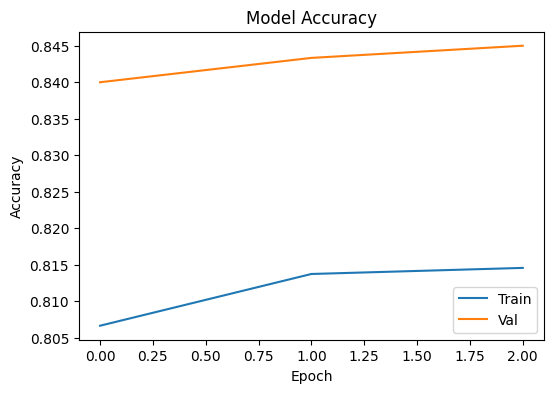

In [ ]:

# ================================
# Plot accuracy
# ================================
plt.figure(figsize=(6,4))
plt.plot(history.history["class_output_accuracy"])
plt.plot(history.history["val_class_output_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Val"])
plt.show()